In [38]:
import numpy as np #계산 준비
import pandas as pd #Table 준비
import matplotlib.pyplot as plt #EDA 준비
import seaborn as sns
plt.rcParams['font.family']='Malgun Gothic'

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV #데이터 분할, 교차분석
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures, LabelEncoder, OneHotEncoder, OrdinalEncoder #데이터 전처리(스케일링)

#분류
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#정밀도 , 민감도, ROC 커브 지표 확인
from sklearn.metrics import classification_report

#앙상블
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

#비지도학습
#군집 분석 - K-means
from sklearn.cluster import KMeans

#실루엣 스코어
from sklearn.metrics import silhouette_score, silhouette_samples

#주성분분석
from sklearn.decomposition import PCA
from matplotlib import cm

In [39]:
df_org=pd.read_csv("./archive/diabetes.csv")
df=df_org
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [41]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [42]:
import pandas as pd

def replace_outliers_iqr_with_mean(df, exclude_columns=['Outcome']):
    """
    DataFrame에서 특정 컬럼을 제외한 각 수치형 컬럼의 이상치를 IQR 방식으로 찾아 평균값으로 대체합니다.

    Args:
        df (pd.DataFrame): 이상치를 대체할 DataFrame.
        exclude_columns (list, optional): 이상치 대체에서 제외할 컬럼 이름 목록.
                                            기본값은 ['Outcome'].

    Returns:
        pd.DataFrame: 이상치가 평균값으로 대체된 새로운 DataFrame.
    """
    df_replaced = df.copy()
    numeric_cols = df_replaced.select_dtypes(include=['number']).columns.tolist()

    for col in numeric_cols:
        if col not in exclude_columns:
            Q1 = df_replaced[col].quantile(0.25)
            Q3 = df_replaced[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # 이상치 찾기
            outliers_lower = df_replaced[col] < lower_bound
            outliers_upper = df_replaced[col] > upper_bound

            # 해당 컬럼의 평균값 계산
            mean_value = df_replaced[col].mean()

            # 이상치를 평균값으로 대체
            df_replaced.loc[outliers_lower, col] = mean_value
            df_replaced.loc[outliers_upper, col] = mean_value

    return df_replaced

# 예시: df라는 DataFrame이 있다고 가정
df_replaced_mean = replace_outliers_iqr_with_mean(df.copy()) # 원본 df를 유지하기 위해 복사본 사용

# 결과 확인 (처음 몇 행 출력)
print("원본 DataFrame:")
print(df.head())
print("\n이상치 평균값으로 대체 후 DataFrame:")
print(df_replaced_mean.head())

원본 DataFrame:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

이상치 평균값으로 대체 후 DataFrame:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0      0.0  33.6   
1          1.0     85.0           66.0           29.0      0.0  26.6   
2          8.0    183.0           64.0        

C:\Users\campus4D006\AppData\Local\Temp\ipykernel_6524\3904240275.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.8450520833333335' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_replaced.loc[outliers_lower, col] = mean_value
C:\Users\campus4D006\AppData\Local\Temp\ipykernel_6524\3904240275.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '120.89453125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_replaced.loc[outliers_lower, col] = mean_value
C:\Users\campus4D006\AppData\Local\Temp\ipykernel_6524\3904240275.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '69.10546875' has dtype incompatible with int64, please explicitly cast to a compat

{'whiskers': [<matplotlib.lines.Line2D at 0x1b23b48b230>,
 'caps': [<matplotlib.lines.Line2D at 0x1b23b488d70>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b23b48b650>,
 'medians': [<matplotlib.lines.Line2D at 0x1b23b48a3c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1b23b489f10>,
 'means': []}

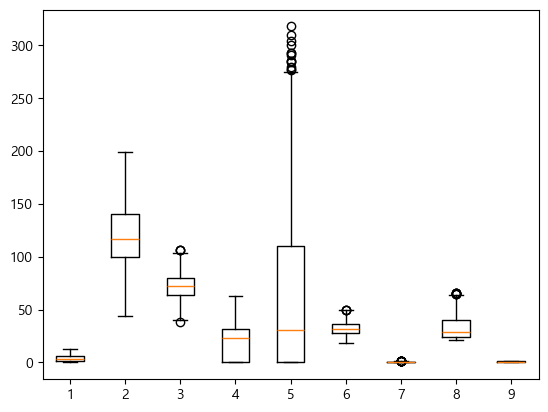

In [43]:
plt.boxplot(df_replaced_mean)

In [44]:
# 예시: df라는 DataFrame이 있다고 가정
df_replaced_mean = replace_outliers_iqr_with_mean(df_replaced_mean.copy())

{'whiskers': [<matplotlib.lines.Line2D at 0x1b23b69e390>,
 'caps': [<matplotlib.lines.Line2D at 0x1b23b69e8a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b23b69e120>,
 'medians': [<matplotlib.lines.Line2D at 0x1b23b69ee40>,
 'fliers': [<matplotlib.lines.Line2D at 0x1b23b69f0b0>,
 'means': []}

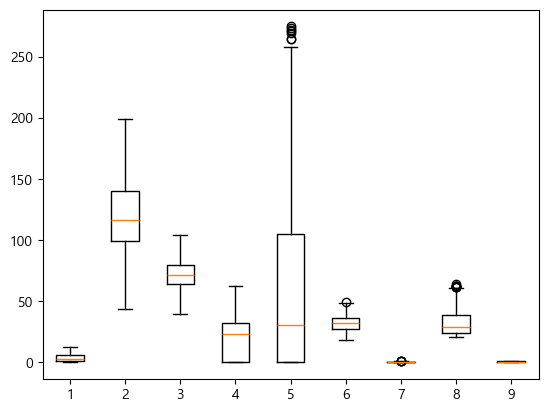

In [45]:
plt.boxplot(df_replaced_mean)

In [46]:
df_replaced_mean = replace_outliers_iqr_with_mean(df_replaced_mean.copy())

{'whiskers': [<matplotlib.lines.Line2D at 0x1b23be25970>,
 'caps': [<matplotlib.lines.Line2D at 0x1b23be25ee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b23be256d0>,
 'medians': [<matplotlib.lines.Line2D at 0x1b23be26420>,
 'fliers': [<matplotlib.lines.Line2D at 0x1b23be266c0>,
 'means': []}

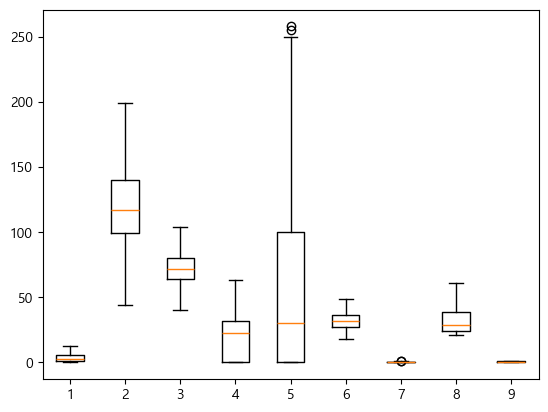

In [47]:
plt.boxplot(df_replaced_mean)

{'whiskers': [<matplotlib.lines.Line2D at 0x1b23bf20cb0>,
 'caps': [<matplotlib.lines.Line2D at 0x1b23bf21280>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b23bf209e0>,
 'medians': [<matplotlib.lines.Line2D at 0x1b23bf217c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1b23bf21a90>,
 'means': []}

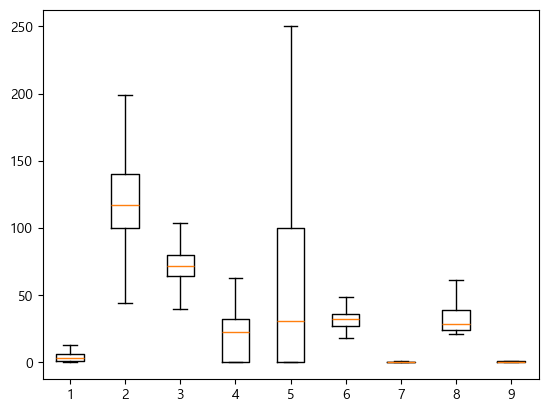

In [48]:
df_replaced_mean = replace_outliers_iqr_with_mean(df_replaced_mean.copy())
plt.boxplot(df_replaced_mean)

In [49]:
df=df_replaced_mean

In [50]:
def count_outliers_iqr(df, exclude_columns=['Outcome']):
    """
    DataFrame에서 특정 컬럼을 제외한 각 수치형 컬럼의 이상치 개수를 IQR 방식으로 계산합니다.

    Args:
        df (pd.DataFrame): 이상치를 검사할 DataFrame.
        exclude_columns (list, optional): 이상치 검사에서 제외할 컬럼 이름 목록.
                                            기본값은 ['Outcome'].

    Returns:
        pd.Series: 각 컬럼별 이상치 개수를 담은 Series.
    """
    outlier_counts = pd.Series(index=df.columns)
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    for col in df.columns:
        if col in numeric_cols and col not in exclude_columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            outlier_counts[col] = len(outliers)
        else:
            outlier_counts[col] = 0  # 수치형이 아니거나 제외된 컬럼은 0으로 설정

    return outlier_counts

# 예시: df라는 DataFrame이 있다고 가정
outlier_counts_per_column = count_outliers_iqr(df)

# 결과 확인
print("컬럼별 이상치 개수:")
print(outlier_counts_per_column)

컬럼별 이상치 개수:
Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64


In [51]:
# 'SkinThickness' 또는 'Insulin' 컬럼이 0인 행을 삭제합니다.
df_no_zeros = df[(df['SkinThickness'] != 0) | (df['Insulin'] != 0)]

# 결과 확인 (삭제된 행 수 확인)
print("원본 DataFrame 크기:", df.shape)
print("0 값 제거 후 DataFrame 크기:", df_no_zeros.shape)

# 필요하다면 인덱스를 재설정할 수 있습니다.
df_no_zeros = df_no_zeros.reset_index(drop=True)
print("\n인덱스 재설정 후:")
print(df_no_zeros.head())

원본 DataFrame 크기: (768, 9)
0 값 제거 후 DataFrame 크기: (541, 9)

인덱스 재설정 후:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0      0.0  33.6   
1          1.0     85.0           66.0           29.0      0.0  26.6   
2          1.0     89.0           66.0           23.0     94.0  28.1   
3          0.0    137.0           40.0           35.0    168.0  43.1   
4          3.0     78.0           50.0           32.0     88.0  31.0   

   DiabetesPedigreeFunction   Age  Outcome  
0                  0.627000  50.0        1  
1                  0.351000  31.0        0  
2                  0.167000  21.0        0  
3                  0.471876  33.0        1  
4                  0.248000  26.0        1  


In [52]:
df=df_no_zeros

In [53]:
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6.0    148.0           72.0           35.0      0.0  33.6   
1            1.0     85.0           66.0           29.0      0.0  26.6   
2            1.0     89.0           66.0           23.0     94.0  28.1   
3            0.0    137.0           40.0           35.0    168.0  43.1   
4            3.0     78.0           50.0           32.0     88.0  31.0   
..           ...      ...            ...            ...      ...   ...   
536          9.0    170.0           74.0           31.0      0.0  44.0   
537         10.0    101.0           76.0           48.0    180.0  32.9   
538          2.0    122.0           70.0           27.0      0.0  36.8   
539          5.0    121.0           72.0           23.0    112.0  26.2   
540          1.0     93.0           70.0           31.0      0.0  30.4   

     DiabetesPedigreeFunction        Age  Outcome  
0                    0.627000  50.000000        1  
1                    0.351000  31.000000        0  
2                    0.167000  21.000000        0  
3                    0.471876  33.000000        1  
4                    0.248000  26.000000        1  
..                        ...        ...      ...  
536                  0.403000  43.000000        1  
537                  0.171000  32.511509        0  
538                  0.340000  27.000000        0  
539                  0.245000  30.000000        0  
540                  0.315000  23.000000        0  

[541 rows x 9 columns]

In [54]:
outcome_1_glucose_mean = df[df['Outcome'] == 1]['Glucose'].mean()
print(f"Outcome이 1일 때 Glucose 평균: {outcome_1_glucose_mean:.2f}")

outcome_0_glucose_mean = df[df['Outcome'] == 0]['Glucose'].mean()
print(f"Outcome이 0일 때 Glucose 평균: {outcome_0_glucose_mean:.2f}")

Outcome이 1일 때 Glucose 평균: 142.79
Outcome이 0일 때 Glucose 평균: 110.04


In [55]:
df=df_no_zeros

In [56]:
df=df[['Glucose', 'BMI', 'Age', 'BloodPressure','Outcome']]

In [57]:
def bmi_category(bmi):
    if bmi < 18.5:
        return 1 #'저체중'
    elif bmi < 23:
        return 2 #'정상'
    elif bmi < 25:
        return 3 #'비만전단계'
    elif bmi < 30:
        return 4 #'비만1단계'
    elif bmi < 35:
        return 5 #'비만2단계'
    else:
        return 6 #'비만3단계'

# df에 'bmi' 컬럼 생성
df['BMI'] = df['BMI'].apply(bmi_category)

C:\Users\campus4D006\AppData\Local\Temp\ipykernel_6524\4255547921.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BMI'] = df['BMI'].apply(bmi_category)


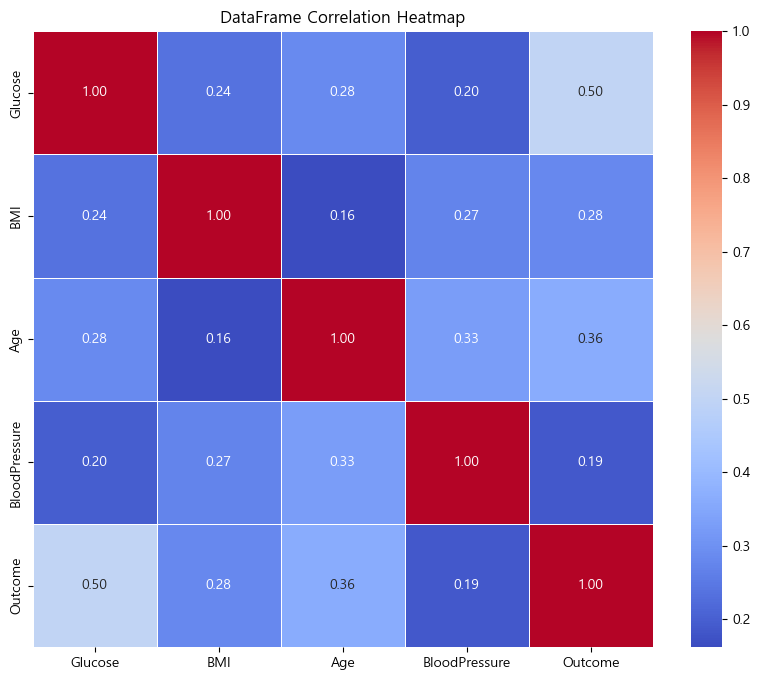

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# df DataFrame이 있다고 가정합니다.

# 상관 행렬 계산
correlation_matrix = df.corr()

# 히트맵 생성
plt.figure(figsize=(10, 8))  # Optional: Adjust figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('DataFrame Correlation Heatmap')
plt.show()

In [59]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 독립 변수 선택 (모델을 만들 때 사용한 컬럼들을 지정해주세요)
X = df[['Glucose', 'BMI', 'Age', 'BloodPressure']]  # 예시: 사용했던 컬럼에 맞춰 수정

# VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

         feature        VIF
0        Glucose  17.223033
1            BMI  19.637194
2            Age  12.991368
3  BloodPressure  29.121953


In [60]:
X = df[['Glucose', 'BMI', 'Age', 'BloodPressure']]
y = df['Outcome']

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 2. 스케일링 대상만 선택 (BMI 제외)
scaler = StandardScaler()
X_train_scaled_part = scaler.fit_transform(X_train[['Glucose', 'Age', 'BloodPressure']])
X_test_scaled_part = scaler.transform(X_test[['Glucose',  'Age', 'BloodPressure']])

# 3. 스케일링된 부분을 DataFrame으로 변환
X_train_scaled_df = pd.DataFrame(
    X_train_scaled_part, 
    columns=['Glucose', 'Age', 'BloodPressure'], 
    index=X_train.index
)
X_test_scaled_df = pd.DataFrame(
    X_test_scaled_part, 
    columns=['Glucose', 'Age', 'BloodPressure'], 
    index=X_test.index
)

# 4. BMI는 원본 그대로 유지
X_train_bmi = X_train[['BMI']]
X_test_bmi = X_test[['BMI']]

# 5. 스케일된 변수 + BMI 합치기
X_train_scaled = pd.concat([X_train_scaled_df, X_train_bmi], axis=1)
X_test_scaled = pd.concat([X_test_scaled_df, X_test_bmi], axis=1)

# 6. 컬럼 순서 확인 (선택)
print("X_train_scaled columns:", X_train_scaled.columns.tolist()) 

X_train_scaled columns: ['Glucose', 'Age', 'BloodPressure', 'BMI']


In [62]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [63]:
# 2. 각 모델별 파라미터 그리드 정의
param_grid_lr = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear']}
param_grid_svc = {'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1], 'kernel': ['rbf']}
param_grid_dt = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10, 15]}

In [64]:
# 3. 각 모델 인스턴스 생성
lr = LogisticRegression(random_state=42)
svc = SVC(random_state=42)
dt = DecisionTreeClassifier(random_state=42)

In [65]:
# 4. GridSearchCV 설정 및 학습 (각 모델별로)
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=3, scoring='accuracy')
grid_search_lr.fit(X_train_scaled, y_train)
print("최적 로지스틱 회귀 파라미터:", grid_search_lr.best_params_)
print("최고 로지스틱 회귀 정확도:", grid_search_lr.best_score_)

print("-" * 30)

grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid_svc, cv=3, scoring='accuracy')
grid_search_svc.fit(X_train_scaled, y_train)
print("최적 SVC 파라미터:", grid_search_svc.best_params_)
print("최고 SVC 정확도:", grid_search_svc.best_score_)

print("-" * 30)

grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=3, scoring='accuracy')
grid_search_dt.fit(X_train_scaled, y_train)
print("최적 결정 트리 파라미터:", grid_search_dt.best_params_)
print("최고 결정 트리 정확도:", grid_search_dt.best_score_)

최적 로지스틱 회귀 파라미터: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
최고 로지스틱 회귀 정확도: 0.7671957671957671
------------------------------
최적 SVC 파라미터: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
최고 SVC 정확도: 0.7671957671957671
------------------------------
최적 결정 트리 파라미터: {'criterion': 'gini', 'max_depth': 5}
최고 결정 트리 정확도: 0.7619047619047619


In [66]:
from sklearn.metrics import classification_report

In [67]:
# 5. (선택 사항) 최적 모델로 테스트 데이터 평가
best_lr_model = grid_search_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test_scaled)
accuracy_lr_test = accuracy_score(y_test, y_pred_lr)
print("테스트 데이터 로지스틱 회귀 정확도:", accuracy_lr_test)
# y_true에는 실제 테스트 데이터의 타겟 값 (y_test)을 넣어줍니다.
y_true = y_test

# y_pred에는 best_lr_model로 예측한 값 (y_pred_lr)을 넣어줍니다.
y_pred = y_pred_lr

# classification_report를 생성하고 출력합니다.
report = classification_report(y_true, y_pred)
print(report)
from sklearn.metrics import f1_score
f1_score(y_test,y_pred_lr)

테스트 데이터 로지스틱 회귀 정확도: 0.8159509202453987
              precision    recall  f1-score   support

           0       0.83      0.91      0.86       106
           1       0.79      0.65      0.71        57

    accuracy                           0.82       163
   macro avg       0.81      0.78      0.79       163
weighted avg       0.81      0.82      0.81       163



0.7115384615384616

In [68]:
best_svc_model = grid_search_svc.best_estimator_
y_pred_svc = best_svc_model.predict(X_test_scaled)
accuracy_svc_test = accuracy_score(y_test, y_pred_svc)
print("테스트 데이터 SVC 정확도:", accuracy_svc_test)
# y_true에는 실제 테스트 데이터의 타겟 값 (y_test)을 넣어줍니다.
y_true = y_test

# y_pred에는 best_lr_model로 예측한 값 (y_pred_lr)을 넣어줍니다.
y_pred = y_pred_svc

# classification_report를 생성하고 출력합니다.
report = classification_report(y_true, y_pred)
print(report)
from sklearn.metrics import f1_score
f1_score(y_test,y_pred_svc)

테스트 데이터 SVC 정확도: 0.803680981595092
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       106
           1       0.77      0.63      0.69        57

    accuracy                           0.80       163
   macro avg       0.79      0.76      0.77       163
weighted avg       0.80      0.80      0.80       163



0.6923076923076923

In [69]:
best_dt_model = grid_search_dt.best_estimator_
y_pred_dt = best_dt_model.predict(X_test_scaled)
accuracy_dt_test = accuracy_score(y_test, y_pred_dt)
print("테스트 데이터 결정 트리 정확도:", accuracy_dt_test)
# y_true에는 실제 테스트 데이터의 타겟 값 (y_test)을 넣어줍니다.
y_true = y_test

# y_pred에는 best_lr_model로 예측한 값 (y_pred_lr)을 넣어줍니다.
y_pred = y_pred_dt

# classification_report를 생성하고 출력합니다.
report = classification_report(y_true, y_pred)
print(report)
from sklearn.metrics import f1_score
f1_score(y_test,y_pred_dt)

테스트 데이터 결정 트리 정확도: 0.7361963190184049
              precision    recall  f1-score   support

           0       0.75      0.90      0.82       106
           1       0.69      0.44      0.54        57

    accuracy                           0.74       163
   macro avg       0.72      0.67      0.68       163
weighted avg       0.73      0.74      0.72       163



0.5376344086021505

In [70]:
# 2. 각 모델별 파라미터 그리드 정의
param_grid_sgd = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [1000, 2000, 3000]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [71]:
# 3. 각 모델 인스턴스 생성
sgd = SGDClassifier(random_state=42)
knn = KNeighborsClassifier()
# 4. GridSearchCV를 사용하여 최적 파라미터 찾기 (SGDClassifier)
grid_search_sgd = GridSearchCV(estimator=sgd, param_grid=param_grid_sgd, cv=3, scoring='accuracy')
grid_search_sgd.fit(X_train_scaled, y_train)
print("최적 SGDClassifier 파라미터:", grid_search_sgd.best_params_)
print("최고 SGDClassifier 정확도:", grid_search_sgd.best_score_)

best_sgd_model = grid_search_sgd.best_estimator_
y_pred_sgd = best_sgd_model.predict(X_test_scaled)
accuracy_sgd_test = accuracy_score(y_test, y_pred_sgd)
print("테스트 데이터 결정 트리 정확도:", accuracy_sgd_test)

print("-" * 30)
# y_true에는 실제 테스트 데이터의 타겟 값 (y_test)을 넣어줍니다.
y_true = y_test

# y_pred에는 best_lr_model로 예측한 값 (y_pred_lr)을 넣어줍니다.
y_pred = y_pred_sgd

# classification_report를 생성하고 출력합니다.
report = classification_report(y_true, y_pred)
print(report)

최적 SGDClassifier 파라미터: {'alpha': 0.0001, 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'l2'}
최고 SGDClassifier 정확도: 0.7857142857142857
테스트 데이터 결정 트리 정확도: 0.6993865030674846
------------------------------
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       106
           1       1.00      0.14      0.25        57

    accuracy                           0.70       163
   macro avg       0.84      0.57      0.53       163
weighted avg       0.79      0.70      0.61       163



In [72]:
from sklearn.metrics import f1_score
f1_score(y_test,y_pred_sgd)

0.24615384615384617

In [73]:
# 5. GridSearchCV를 사용하여 최적 파라미터 찾기 (KNeighborsClassifier)
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=3, scoring='accuracy')
grid_search_knn.fit(X_train_scaled, y_train)
print("최적 KNeighborsClassifier 파라미터:", grid_search_knn.best_params_)
print("최고 KNeighborsClassifier 정확도:", grid_search_knn.best_score_)
best_knn_model = grid_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_test_scaled)
accuracy_knn_test = accuracy_score(y_test, y_pred_knn)
print("테스트 데이터 KNeighborsClassifier 정확도:", accuracy_knn_test)
# y_true에는 실제 테스트 데이터의 타겟 값 (y_test)을 넣어줍니다.
y_true = y_test

# y_pred에는 best_lr_model로 예측한 값 (y_pred_lr)을 넣어줍니다.
y_pred = y_pred_knn

# classification_report를 생성하고 출력합니다.
report = classification_report(y_true, y_pred)
print(report)
from sklearn.metrics import f1_score
f1_score(y_test,y_pred_knn)

최적 KNeighborsClassifier 파라미터: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}
최고 KNeighborsClassifier 정확도: 0.7513227513227513
테스트 데이터 KNeighborsClassifier 정확도: 0.7852760736196319
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       106
           1       0.74      0.60      0.66        57

    accuracy                           0.79       163
   macro avg       0.77      0.74      0.75       163
weighted avg       0.78      0.79      0.78       163



0.6601941747572816

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# 1. 랜덤포레스트 모델 생성
rf = RandomForestClassifier(random_state=42)
# 2. 파라미터 그리드 정의
param_grid_rf = {
    'n_estimators': [100, 200, 300],       # 트리 개수
    'max_depth': [None, 5, 10, 20],        # 최대 깊이
    'min_samples_split': [2, 5],           # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 2],            # 리프 노드가 되기 위한 최소 샘플 수
    'criterion': ['gini', 'entropy']       # 불순도 기준
}
# 3. GridSearchCV 수행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, scoring='accuracy')
grid_search_rf.fit(X_train_scaled, y_train) 
# 4. 결과 출력
print("최적 랜덤포레스트 파라미터:", grid_search_rf.best_params_)
print("최고 교차검증 정확도:", grid_search_rf.best_score_)


최적 랜덤포레스트 파라미터: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
최고 교차검증 정확도: 0.7724867724867724


In [75]:
# 5. 테스트 데이터 평가
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_scaled)
accuracy_rf_test = accuracy_score(y_test, y_pred_rf)
print("테스트 데이터 랜덤포레스트 정확도:", accuracy_rf_test)

테스트 데이터 랜덤포레스트 정확도: 0.8282208588957055


In [76]:
from sklearn.metrics import f1_score
f1_score(y_test,y_pred_rf)

0.7454545454545455

In [77]:
# classification_report를 생성하고 출력합니다.
y_true = y_test
y_pred_rf = best_rf_model.predict(X_test_scaled)

report = classification_report(y_true, y_pred_rf)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       106
           1       0.77      0.72      0.75        57

    accuracy                           0.83       163
   macro avg       0.81      0.80      0.81       163
weighted avg       0.83      0.83      0.83       163



In [78]:
# 2. 개별 분류 모델 인스턴스 생성 (하이퍼파라미터는 필요에 따라 튜닝된 값으로 설정)
# 예시로 기본적인 파라미터로 설정했습니다. GridSearchCV 결과를 사용하시면 더 좋습니다.
clf1 = LogisticRegression(random_state=42)
clf2 = SVC(random_state=42, probability=True) # soft voting을 위해 probability=True 설정
clf3 = RandomForestClassifier(random_state=42)

# 3. 앙상블 모델 생성 (VotingClassifier)
# estimators 파라미터에 튜플 형태로 모델 이름과 인스턴스를 전달합니다.
# voting 파라미터는 'hard' (다수결 투표) 또는 'soft' (확률 평균)를 선택할 수 있습니다.
# SVC의 경우 soft voting을 사용하려면 probability=True로 설정해야 합니다.
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('rf', clf3)], voting='hard')
eclf1 = eclf1.fit(X_train_scaled, y_train)
y_pred_hard = eclf1.predict(X_test_scaled)
accuracy_hard = accuracy_score(y_test, y_pred_hard)
report_hard = classification_report(y_test, y_pred_hard)
print("하드 보팅 앙상블 모델 정확도:", accuracy_hard)
print("하드 보팅 앙상블 모델 보고서:\n", report_hard)

print("-" * 30)

eclf2 = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('rf', clf3)], voting='soft')
eclf2 = eclf2.fit(X_train_scaled, y_train)
y_pred_soft = eclf2.predict(X_test_scaled)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
report_soft = classification_report(y_test, y_pred_soft)
print("소프트 보팅 앙상블 모델 정확도:", accuracy_soft)
print("소프트 보팅 앙상블 모델 보고서:\n", report_soft)

하드 보팅 앙상블 모델 정확도: 0.8159509202453987
하드 보팅 앙상블 모델 보고서:
               precision    recall  f1-score   support

           0       0.83      0.91      0.86       106
           1       0.79      0.65      0.71        57

    accuracy                           0.82       163
   macro avg       0.81      0.78      0.79       163
weighted avg       0.81      0.82      0.81       163

------------------------------
소프트 보팅 앙상블 모델 정확도: 0.8159509202453987
소프트 보팅 앙상블 모델 보고서:
               precision    recall  f1-score   support

           0       0.83      0.91      0.86       106
           1       0.79      0.65      0.71        57

    accuracy                           0.82       163
   macro avg       0.81      0.78      0.79       163
weighted avg       0.81      0.82      0.81       163



In [79]:
from sklearn.metrics import f1_score
f1_score(y_test,y_pred_hard)

0.7115384615384616

In [80]:
from sklearn.metrics import f1_score
f1_score(y_test,y_pred_soft)

0.7115384615384616

# 모델 적용

## df1

In [81]:
df_org1=pd.read_csv("./archive/cluster_result_not_cholesterol.csv")
df1=df_org1
df_org2=pd.read_csv("./archive/cluster_result.csv")
df2=df_org2

In [82]:
df1=df1[['식전혈당(공복혈당)','BMI구분','new_연령대','이완기혈압','cluster']]

In [83]:
df1

식전혈당(공복혈당)  BMI구분 new_연령대  이완기혈압  cluster
0             93.0      1     20대   60.0        0
1             90.0      2     20대   67.0        0
2             88.0      4     30대   82.0        2
3            114.0      4     20대   91.0        2
4             93.0      2     30대   68.0        1
...            ...    ...     ...    ...      ...
121302        93.0      2     20대   61.0        0
121303        96.0      2     20대   67.0        0
121304       100.0      2     30대   82.0        1
121305        95.0      3     30대   81.0        1
121306       105.0      2     30대   71.0        1

[121307 rows x 5 columns]

In [84]:
# 연령대별 대표 나이 매핑
age_mapping = {'20대': 25, '30대': 35, '40대': 45, '50대': 55}

# 'Age'라는 새로운 컬럼을 만들고 매핑을 적용합니다.
df1['Age'] = df1['new_연령대'].map(age_mapping)

C:\Users\campus4D006\AppData\Local\Temp\ipykernel_6524\2661994964.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Age'] = df1['new_연령대'].map(age_mapping)


In [85]:
df1 = df1.drop('new_연령대', axis=1)

In [86]:
df1

식전혈당(공복혈당)  BMI구분  이완기혈압  cluster  Age
0             93.0      1   60.0        0   25
1             90.0      2   67.0        0   25
2             88.0      4   82.0        2   35
3            114.0      4   91.0        2   25
4             93.0      2   68.0        1   35
...            ...    ...    ...      ...  ...
121302        93.0      2   61.0        0   25
121303        96.0      2   67.0        0   25
121304       100.0      2   82.0        1   35
121305        95.0      3   81.0        1   35
121306       105.0      2   71.0        1   35

[121307 rows x 5 columns]

In [87]:
import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split # 모델 학습 부분은 설명을 위해 포함

In [88]:
# df1의 컬럼명 변경
df1_renamed = df1.rename(columns={'식전혈당(공복혈당)': 'Glucose',
                                   'BMI구분': 'BMI',
                                   '이완기혈압': 'BloodPressure'})
df1_renamed

Glucose  BMI  BloodPressure  cluster  Age
0          93.0    1           60.0        0   25
1          90.0    2           67.0        0   25
2          88.0    4           82.0        2   35
3         114.0    4           91.0        2   25
4          93.0    2           68.0        1   35
...         ...  ...            ...      ...  ...
121302     93.0    2           61.0        0   25
121303     96.0    2           67.0        0   25
121304    100.0    2           82.0        1   35
121305     95.0    3           81.0        1   35
121306    105.0    2           71.0        1   35

[121307 rows x 5 columns]

In [89]:
# cluster 값이 0인 데이터프레임 생성
cluster_0_df = df1_renamed[df1_renamed['cluster'] == 0]

# cluster 값이 1인 데이터프레임 생성
cluster_1_df = df1_renamed[df1_renamed['cluster'] == 1]

# cluster 값이 2인 데이터프레임 생성
cluster_2_df = df1_renamed[df1_renamed['cluster'] == 2]

In [90]:
cluster_0_df=cluster_0_df.drop('cluster',axis=1)
cluster_1_df=cluster_1_df.drop('cluster',axis=1)
cluster_2_df=cluster_2_df.drop('cluster',axis=1)

In [91]:
# 1# 1. Glucose, Age, BloodPressure 스케일링 (학습 데이터 기준 scaler 사용)
scaled_0 = scaler.transform(cluster_0_df[['Glucose', 'Age', 'BloodPressure']])
scaled_0_df = pd.DataFrame(scaled_0, columns=['Glucose', 'Age', 'BloodPressure'], index=cluster_0_df.index)

# 2. BMI는 스케일링하지 않고 원본 그대로 사용
bmi_0 = cluster_0_df[['BMI']]

# 3. 스케일링된 연속형 변수 + BMI 병합
cluster_0_scaled = pd.concat([scaled_0_df, bmi_0], axis=1)

# 4. 컬럼 순서를 학습 데이터와 동일하게 맞추기 (★ 중요!)
cluster_0_scaled = cluster_0_scaled[X_train_scaled.columns]

In [92]:
# 1# 1. Glucose, Age, BloodPressure 스케일링 (학습 데이터 기준 scaler 사용)
scaled_1 = scaler.transform(cluster_1_df[['Glucose', 'Age', 'BloodPressure']])
scaled_1_df = pd.DataFrame(scaled_1, columns=['Glucose', 'Age', 'BloodPressure'], index=cluster_1_df.index)

# 2. BMI는 스케일링하지 않고 원본 그대로 사용
bmi_1 = cluster_1_df[['BMI']]

# 3. 스케일링된 연속형 변수 + BMI 병합
cluster_1_scaled = pd.concat([scaled_1_df, bmi_1], axis=1)

# 4. 컬럼 순서를 학습 데이터와 동일하게 맞추기 (★ 중요!)
cluster_1_scaled = cluster_1_scaled[X_train_scaled.columns]

In [93]:
# 1# 1. Glucose, Age, BloodPressure 스케일링 (학습 데이터 기준 scaler 사용)
scaled_2 = scaler.transform(cluster_2_df[['Glucose', 'Age', 'BloodPressure']])
scaled_2_df = pd.DataFrame(scaled_2, columns=['Glucose', 'Age', 'BloodPressure'], index=cluster_2_df.index)

# 2. BMI는 스케일링하지 않고 원본 그대로 사용
bmi_2 = cluster_2_df[['BMI']]

# 3. 스케일링된 연속형 변수 + BMI 병합
cluster_2_scaled = pd.concat([scaled_2_df, bmi_2], axis=1)

# 4. 컬럼 순서를 학습 데이터와 동일하게 맞추기 (★ 중요!)
cluster_2_scaled = cluster_2_scaled[X_train_scaled.columns]

In [94]:
# 2. 예측에 사용할 Feature 선택 (학습 시 사용된 순서와 동일하게 하는 것이 좋습니다)
df0_processed_for_prediction = cluster_0_scaled

# 3. df1 예측
predictions_df0 = best_rf_model.predict(df0_processed_for_prediction)
print("cluster 0 예측 결과:", predictions_df0)

cluster 0 예측 결과: [0 0 0 ... 0 0 0]


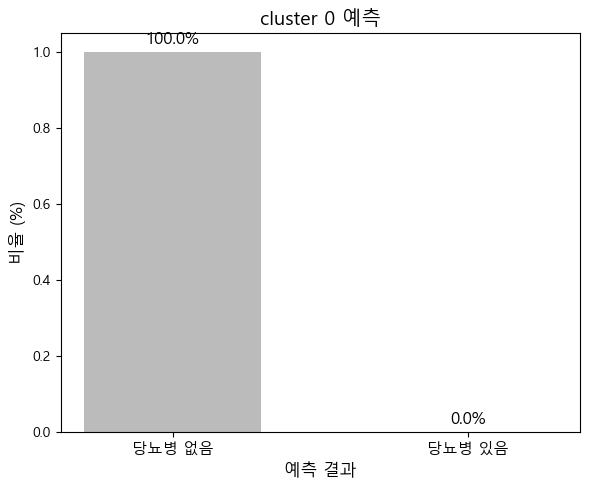

In [95]:
# 색상 정의
light_Gray = '#BBBBBB'
iM_Mint = '#00C7A9'

# 예측값 비율 계산
count_0 = sum(predictions_df0 == 0)
count_1 = sum(predictions_df0 == 1)
total = count_0 + count_1
ratios = [count_0 / total, count_1 / total]

# 시각화
plt.figure(figsize=(6, 5))
bars = plt.bar([0, 1], ratios, color=[light_Gray, iM_Mint], width=0.6)

# 비율 텍스트 추가
for bar, ratio in zip(bars, ratios):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{ratio:.1%}', ha='center', va='bottom', fontsize=12)

# 꾸미기
plt.xticks([0, 1], ['당뇨병 없음', '당뇨병 있음'], fontsize=11)
plt.ylabel('비율 (%)', fontsize=12)
plt.xlabel('예측 결과', fontsize=12)
plt.title('cluster 0 예측', fontsize=14, color='black')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

In [96]:
unique_values, counts = np.unique(predictions_df0, return_counts=True)

for i in range(len(unique_values)):
    print(f"예측값 {unique_values[i]}의 개수: {counts[i]}")

예측값 0의 개수: 47073


In [97]:
# 2. 예측에 사용할 Feature 선택 (학습 시 사용된 순서와 동일하게 하는 것이 좋습니다)
df1_processed_for_prediction = cluster_1_scaled

# 3. df1 예측
predictions_df1 = best_rf_model.predict(df1_processed_for_prediction)
print("Cluster 1 예측 결과:", predictions_df1)

Cluster 1 예측 결과: [0 0 0 ... 0 0 0]


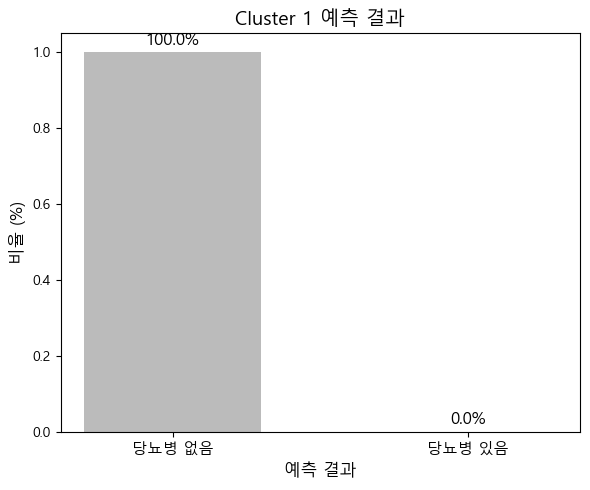

In [98]:
# iM 컬러
light_Gray = '#BBBBBB'
iM_Mint = '#00C7A9'

# 예측 비율 계산
count_0 = sum(predictions_df1 == 0)
count_1 = sum(predictions_df1 == 1)
total = count_0 + count_1
ratios = [count_0 / total, count_1 / total]
labels = ['당뇨병 없음', '당뇨병 있음']
colors = [light_Gray, iM_Mint]

# 시각화
plt.figure(figsize=(6, 5))
bars = plt.bar([0, 1], ratios, color=colors, width=0.6)

# 비율 텍스트 표시
for bar, ratio in zip(bars, ratios):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{ratio:.1%}', ha='center', va='bottom', fontsize=12)

# 라벨 및 제목
plt.xticks([0, 1], labels, fontsize=11)
plt.xlabel('예측 결과', fontsize=12)
plt.ylabel('비율 (%)', fontsize=12)
plt.title('Cluster 1 예측 결과', fontsize=14, color='black')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

In [99]:
unique_values, counts = np.unique(predictions_df1, return_counts=True)

for i in range(len(unique_values)):
    print(f"예측값 {unique_values[i]}의 개수: {counts[i]}")

예측값 0의 개수: 54399
예측값 1의 개수: 10


In [100]:
# 2. 예측에 사용할 Feature 선택 (학습 시 사용된 순서와 동일하게 하는 것이 좋습니다)
df2_processed_for_prediction = cluster_2_scaled

# 3. df1 예측
predictions_df2 = best_rf_model.predict(df2_processed_for_prediction)
print("Cluster 2 예측 결과:", predictions_df2)

Cluster 2 예측 결과: [0 0 0 ... 0 0 0]


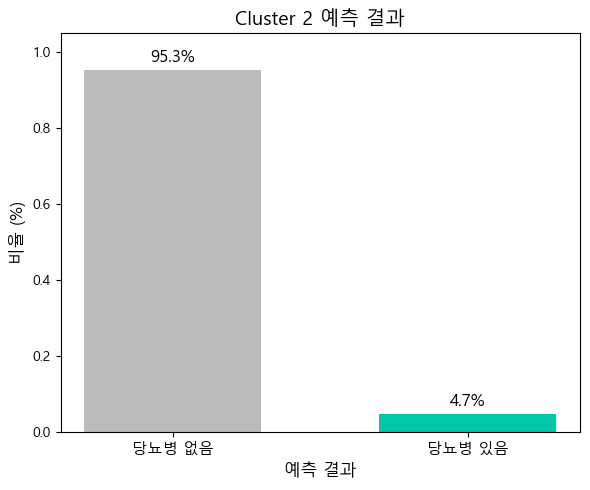

In [101]:
# iM 컬러
light_Gray = '#BBBBBB'
iM_Mint = '#00C7A9'

# 예측 비율 계산
count_0 = sum(predictions_df2 == 0)
count_1 = sum(predictions_df2 == 1)
total = count_0 + count_1
ratios = [count_0 / total, count_1 / total]
labels = ['당뇨병 없음', '당뇨병 있음']
colors = [light_Gray, iM_Mint]

# 시각화
plt.figure(figsize=(6, 5))
bars = plt.bar([0, 1], ratios, color=colors, width=0.6)

# 비율 텍스트 표시
for bar, ratio in zip(bars, ratios):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{ratio:.1%}', ha='center', va='bottom', fontsize=12)

# 라벨 및 제목
plt.xticks([0, 1], labels, fontsize=11)
plt.xlabel('예측 결과', fontsize=12)
plt.ylabel('비율 (%)', fontsize=12)
plt.title('Cluster 2 예측 결과', fontsize=14, color='black')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

In [102]:
unique_values, counts = np.unique(predictions_df2, return_counts=True)

for i in range(len(unique_values)):
    print(f"예측값 {unique_values[i]}의 개수: {counts[i]}")

예측값 0의 개수: 18891
예측값 1의 개수: 934


In [103]:
# '식전혈당(공복혈당)' 컬럼 값에 따라 새로운 '당뇨병여부' 컬럼 생성
df1['당뇨병여부'] = df1['식전혈당(공복혈당)'].apply(lambda x: 1 if x >= 125 else 0)

# 결과 확인 (처음 몇 행 출력)
print(df1[['식전혈당(공복혈당)', '당뇨병여부']].head())

   식전혈당(공복혈당)  당뇨병여부
0        93.0      0
1        90.0      0
2        88.0      0
3       114.0      0
4        93.0      0


In [104]:
# df1의 컬럼명 변경
df1_renamed = df1.rename(columns={'식전혈당(공복혈당)': 'Glucose',
                                   'BMI구분': 'BMI',
                                   '이완기혈압': 'BloodPressure',
                                 '연령대':'Age'})

In [105]:
df1_renamed

Glucose  BMI  BloodPressure  cluster  Age  당뇨병여부
0          93.0    1           60.0        0   25      0
1          90.0    2           67.0        0   25      0
2          88.0    4           82.0        2   35      0
3         114.0    4           91.0        2   25      0
4          93.0    2           68.0        1   35      0
...         ...  ...            ...      ...  ...    ...
121302     93.0    2           61.0        0   25      0
121303     96.0    2           67.0        0   25      0
121304    100.0    2           82.0        1   35      0
121305     95.0    3           81.0        1   35      0
121306    105.0    2           71.0        1   35      0

[121307 rows x 6 columns]

In [106]:
df1_renamed = df1_renamed[['Glucose', 'BMI', 'Age', 'BloodPressure','당뇨병여부']]

In [107]:
df1_renamed

Glucose  BMI  Age  BloodPressure  당뇨병여부
0          93.0    1   25           60.0      0
1          90.0    2   25           67.0      0
2          88.0    4   35           82.0      0
3         114.0    4   25           91.0      0
4          93.0    2   35           68.0      0
...         ...  ...  ...            ...    ...
121302     93.0    2   25           61.0      0
121303     96.0    2   25           67.0      0
121304    100.0    2   35           82.0      0
121305     95.0    3   35           81.0      0
121306    105.0    2   35           71.0      0

[121307 rows x 5 columns]

In [108]:
# # '당뇨병여부' 컬럼을 타겟 변수 y로 설정
# y = df1_renamed['당뇨병여부']

# # '당뇨병여부' 컬럼을 제외한 나머지 컬럼을 특성 변수 X로 설정
# X = df1_renamed.drop('당뇨병여부', axis=1)

# # 데이터를 학습용과 테스트용으로 분리
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # 특성 데이터 스케일링 (모델 학습 시 스케일링을 했다면)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # 모델 학습 (best_lr_model이 이미 학습된 모델이라면 이 단계는 건너뛸 수 있습니다.)
# # best_lr_model = LogisticRegression(random_state=42) # 예시
# best_rf_model.fit(X_train_scaled, y_train)

# # 테스트 데이터로 예측
# y_pred = best_rf_model.predict(X_test_scaled)

# # 모델 평가
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print("모델 정확도:", accuracy)
# print("분류 보고서:\n", report)

## df2

In [109]:
df2=df_org2
df2

Unnamed: 0  성별  연령대   허리둘레  시력(좌)  시력(우)  청력(좌)  청력(우)  수축기혈압  이완기혈압  \
0                0   0   13   85.0    1.0    1.2    1.0    1.0  116.0   64.0   
1                1   0    8   93.0    1.2    1.2    1.0    1.0  119.0   76.0   
2                2   0    9   96.1    0.1    0.2    1.0    1.0  131.0   86.0   
3                3   0   17   91.0    1.0    0.9    2.0    2.0  122.0   52.0   
4                4   0   13  104.0    1.2    1.2    1.0    1.0  125.0   55.0   
...            ...  ..  ...    ...    ...    ...    ...    ...    ...    ...   
100323      100323   0    5   68.0    1.5    1.5    1.0    1.0  103.0   64.0   
100324      100324   1   11   81.5    1.2    0.6    1.0    1.0  118.0   78.0   
100325      100325   1   16   92.0    1.0    0.9    1.0    1.0  137.0   71.0   
100326      100326   1   10   94.0    0.9    0.9    1.0    1.0  130.0   80.0   
100327      100327   1   12   71.1    0.8    1.0    1.0    1.0  122.0   82.0   

        ...  cluster      사구체여과율       신장질환군  간질환군     고혈압군  빈혈군        당뇨군  \
0       ...        1   90.878589          정상     0    정상 혈압    0       정상혈당   
1       ...        1   80.057281  신장기능 감소 시작     1    정상 혈압    1       정상혈당   
2       ...        1  112.674981          정상     1  고혈압 전단계    1       정상혈당   
3       ...        1   85.864348  신장기능 감소 시작     0  고혈압 전단계    0  공복혈당장애 의심   
4       ...        1  104.109794          정상     0  고혈압 전단계    0       정상혈당   
...     ...      ...         ...         ...   ...      ...  ...        ...   
100323  ...        1   88.968031  신장기능 감소 시작     0    정상 혈압    0       정상혈당   
100324  ...        0   93.395302          정상     0    정상 혈압    0  공복혈당장애 의심   
100325  ...        1  127.159218          정상     0  고혈압 전단계    0  공복혈당장애 의심   
100326  ...        0  113.892320          정상     0  고혈압 전단계    1       정상혈당   
100327  ...        1   91.670820          정상     0  고혈압 전단계    1       정상혈당   

        청력  평균시력  이상지질혈증군  
0        1   1.1        1  
1        1   1.2        0  
2        1   0.2        0  
3        3   1.0        1  
4        1   1.2        1  
...     ..   ...      ...  
100323   1   1.5        0  
100324   1   0.9        1  
100325   1   1.0        1  
100326   1   0.9        1  
100327   1   0.9        1  

[100328 rows x 36 columns]

In [110]:
df2=df2[['식전혈당(공복혈당)','BMI구분','연령대','이완기혈압','cluster']]

In [111]:
# df2 라는 DataFrame이 있다고 가정합니다.
# '이상지질혈증군' 컬럼 값이 1인 행만 선택하여 df2에 다시 저장합니다.
#이상지질혈증군이있는사람중에 당뇨병이 걸릴 확률
# df2 = df2[df2['이상지질혈증군'] == 1]
# df2

In [112]:
# df2=df2.drop('이상지질혈증군',axis=1)

In [113]:
def categorize_age(age):
    if age == 1 or age == 2:
        return 5
    elif age == 3 or age == 4:
        return 15
    elif age == 5 or age == 6:
        return 25
    elif age == 7 or age == 8:
        return 35
    elif age == 9 or age == 10:
        return 45
    elif age == 11 or age == 12:
        return 55
    elif age == 13 or age == 14:
        return 65
    elif age == 15 or age == 16:
        return 75
    elif age == 17 or age == 18:
        return 85
    else:
        return None 

# 적용
df2['연령대'] = df2['연령대'].apply(categorize_age)

C:\Users\campus4D006\AppData\Local\Temp\ipykernel_6524\719266968.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['연령대'] = df2['연령대'].apply(categorize_age)


In [114]:
df2

식전혈당(공복혈당)  BMI구분  연령대  이완기혈압  cluster
0             98.0      4   65   64.0        1
1             92.0      4   35   76.0        1
2             92.0      4   45   86.0        1
3            102.0      4   85   52.0        1
4             97.0      5   65   55.0        1
...            ...    ...  ...    ...      ...
100323        91.0      2   25   64.0        1
100324       108.0      2   55   78.0        0
100325       121.0      4   75   71.0        1
100326        88.0      5   45   80.0        0
100327        90.0      2   55   82.0        1

[100328 rows x 5 columns]

In [115]:
# df1의 컬럼명 변경
df2_renamed = df2.rename(columns={'식전혈당(공복혈당)': 'Glucose',
                                   'BMI구분': 'BMI',
                                   '이완기혈압': 'BloodPressure',
                                 '연령대': 'Age'})

In [116]:
df2_renamed

Glucose  BMI  Age  BloodPressure  cluster
0          98.0    4   65           64.0        1
1          92.0    4   35           76.0        1
2          92.0    4   45           86.0        1
3         102.0    4   85           52.0        1
4          97.0    5   65           55.0        1
...         ...  ...  ...            ...      ...
100323     91.0    2   25           64.0        1
100324    108.0    2   55           78.0        0
100325    121.0    4   75           71.0        1
100326     88.0    5   45           80.0        0
100327     90.0    2   55           82.0        1

[100328 rows x 5 columns]

In [117]:
df2_renamed1=df2_renamed.copy()

In [118]:
df2_renamed1['당뇨병여부'] = df2_renamed1['Glucose'].apply(lambda x: 1 if x >= 126 else 0)

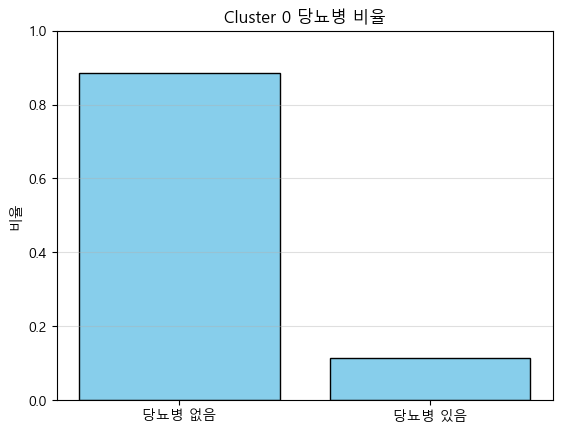

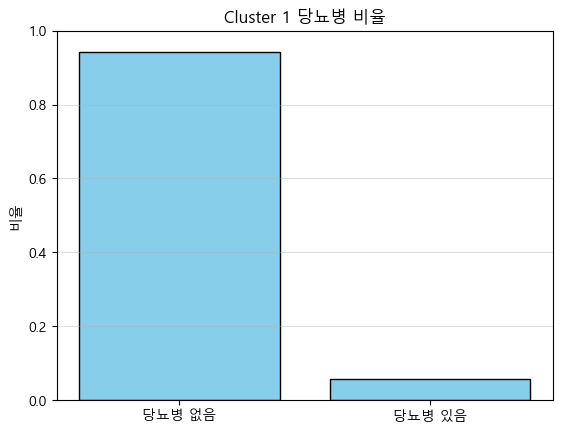

In [119]:
def plot_diabetes_bar(cluster_df, cluster_name):
    counts = cluster_df['당뇨병여부'].value_counts().sort_index()
    labels = ['당뇨병 없음', '당뇨병 있음']
    
    # 비율 계산
    proportions = counts / counts.sum()

    plt.bar(labels, proportions.values, color='skyblue', edgecolor='black')
    plt.title(f'{cluster_name} 당뇨병 비율')
    plt.ylabel('비율')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.4)
    plt.show()

cluster_0 = df2_renamed1[df2_renamed1['cluster'] == 0]
cluster_1 = df2_renamed1[df2_renamed1['cluster'] == 1]

# 클러스터 0
plot_diabetes_bar(cluster_0, "Cluster 0")

# 클러스터 1
plot_diabetes_bar(cluster_1, "Cluster 1")

In [120]:
# cluster 값이 0인 데이터프레임 생성
cluster_0_df = df2_renamed[df2_renamed['cluster'] == 0]

# cluster 값이 1인 데이터프레임 생성
cluster_1_df = df2_renamed[df2_renamed['cluster'] == 1]

In [121]:
cluster_0_df=cluster_0_df.drop('cluster',axis=1)
cluster_1_df=cluster_1_df.drop('cluster',axis=1)

In [122]:
# 1# 1. Glucose, Age, BloodPressure 스케일링 (학습 데이터 기준 scaler 사용)
scaled_0 = scaler.transform(cluster_0_df[['Glucose', 'Age', 'BloodPressure']])
scaled_0_df = pd.DataFrame(scaled_0, columns=['Glucose', 'Age', 'BloodPressure'], index=cluster_0_df.index)

# 2. BMI는 스케일링하지 않고 원본 그대로 사용
bmi_0 = cluster_0_df[['BMI']]

# 3. 스케일링된 연속형 변수 + BMI 병합
cluster_0_scaled = pd.concat([scaled_0_df, bmi_0], axis=1)

# 4. 컬럼 순서를 학습 데이터와 동일하게 맞추기 (★ 중요!)
cluster_0_scaled = cluster_0_scaled[X_train_scaled.columns]

In [123]:
# 1# 1. Glucose, Age, BloodPressure 스케일링 (학습 데이터 기준 scaler 사용)
scaled_1 = scaler.transform(cluster_1_df[['Glucose', 'Age', 'BloodPressure']])
scaled_1_df = pd.DataFrame(scaled_1, columns=['Glucose', 'Age', 'BloodPressure'], index=cluster_1_df.index)

# 2. BMI는 스케일링하지 않고 원본 그대로 사용
bmi_1 = cluster_1_df[['BMI']]

# 3. 스케일링된 연속형 변수 + BMI 병합
cluster_1_scaled = pd.concat([scaled_1_df, bmi_1], axis=1)

# 4. 컬럼 순서를 학습 데이터와 동일하게 맞추기 (★ 중요!)
cluster_1_scaled = cluster_1_scaled[X_train_scaled.columns]

In [124]:
# 2. 예측에 사용할 Feature 선택 (학습 시 사용된 순서와 동일하게 하는 것이 좋습니다)
# df1_processed_for_prediction = cluster_0_df[['Glucose', 'BMI', 'Age', 'BloodPressure']]
df0_processed_for_prediction = cluster_0_scaled

# 3. df1 예측
predictions_df0 = best_rf_model.predict(df0_processed_for_prediction)
print("cluster 0 예측 결과:", predictions_df0)

cluster 0 예측 결과: [0 0 0 ... 1 0 0]


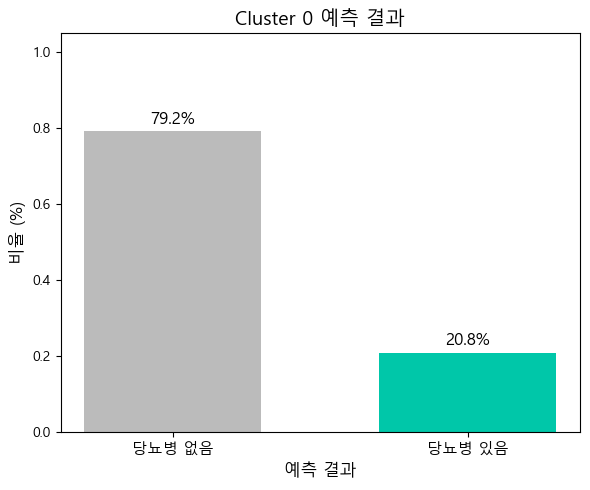

In [125]:
# iM 컬러
light_Gray = '#BBBBBB'
iM_Mint = '#00C7A9'

# 예측 비율 계산
count_0 = sum(predictions_df0 == 0)
count_1 = sum(predictions_df0 == 1)
total = count_0 + count_1
ratios = [count_0 / total, count_1 / total]
labels = ['당뇨병 없음', '당뇨병 있음']
colors = [light_Gray, iM_Mint]

# 시각화
plt.figure(figsize=(6, 5))
bars = plt.bar([0, 1], ratios, color=colors, width=0.6)

# 비율 텍스트 표시
for bar, ratio in zip(bars, ratios):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{ratio:.1%}', ha='center', va='bottom', fontsize=12)

# 라벨 및 제목
plt.xticks([0, 1], labels, fontsize=11)
plt.xlabel('예측 결과', fontsize=12)
plt.ylabel('비율 (%)', fontsize=12)
plt.title('Cluster 0 예측 결과', fontsize=14, color='black')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

In [126]:
unique_values, counts = np.unique(predictions_df0, return_counts=True)

for i in range(len(unique_values)):
    print(f"예측값 {unique_values[i]}의 개수: {counts[i]}")

예측값 0의 개수: 19427
예측값 1의 개수: 5112


In [127]:
# 2. 예측에 사용할 Feature 선택 (학습 시 사용된 순서와 동일하게 하는 것이 좋습니다)
# df1_processed_for_prediction = cluster_1_df[['Glucose', 'BMI', 'Age', 'BloodPressure']]
df1_processed_for_prediction = cluster_1_scaled
# 3. df1 예측
predictions_df1 = best_rf_model.predict(df1_processed_for_prediction)
print("cluster 1 예측 결과:", predictions_df1)

cluster 1 예측 결과: [0 0 0 ... 0 0 0]


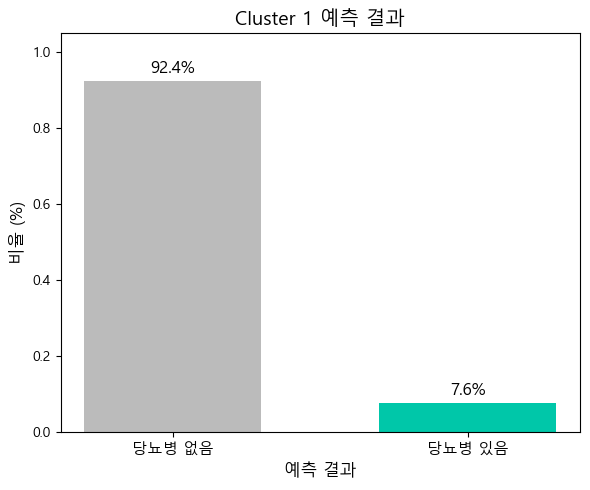

In [128]:
# iM 컬러
light_Gray = '#BBBBBB'
iM_Mint = '#00C7A9'

# 예측 비율 계산
count_0 = sum(predictions_df1 == 0)
count_1 = sum(predictions_df1 == 1)
total = count_0 + count_1
ratios = [count_0 / total, count_1 / total]
labels = ['당뇨병 없음', '당뇨병 있음']
colors = [light_Gray, iM_Mint]

# 시각화
plt.figure(figsize=(6, 5))
bars = plt.bar([0, 1], ratios, color=colors, width=0.6)

# 비율 텍스트 표시
for bar, ratio in zip(bars, ratios):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{ratio:.1%}', ha='center', va='bottom', fontsize=12)

# 라벨 및 제목
plt.xticks([0, 1], labels, fontsize=11)
plt.xlabel('예측 결과', fontsize=12)
plt.ylabel('비율 (%)', fontsize=12)
plt.title('Cluster 1 예측 결과', fontsize=14, color='black')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

In [129]:
unique_values, counts = np.unique(predictions_df1, return_counts=True)

for i in range(len(unique_values)):
    print(f"예측값 {unique_values[i]}의 개수: {counts[i]}")

예측값 0의 개수: 70063
예측값 1의 개수: 5726


In [130]:
# '식전혈당(공복혈당)' 컬럼 값에 따라 새로운 '당뇨병여부' 컬럼 생성
df2['당뇨병여부'] = df2['식전혈당(공복혈당)'].apply(lambda x: 1 if x >= 126 else 0)

# 결과 확인 (처음 몇 행 출력)
print(df2[['식전혈당(공복혈당)', '당뇨병여부']].head())

   식전혈당(공복혈당)  당뇨병여부
0        98.0      0
1        92.0      0
2        92.0      0
3       102.0      0
4        97.0      0


C:\Users\campus4D006\AppData\Local\Temp\ipykernel_6524\451624027.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['당뇨병여부'] = df2['식전혈당(공복혈당)'].apply(lambda x: 1 if x >= 126 else 0)


In [131]:
# df1의 컬럼명 변경
df2_renamed = df2.rename(columns={'식전혈당(공복혈당)': 'Glucose',
                                   'BMI구분': 'BMI',
                                   '이완기혈압': 'BloodPressure',
                                 '연령대':'Age'})

In [132]:
df2_renamed

Glucose  BMI  Age  BloodPressure  cluster  당뇨병여부
0          98.0    4   65           64.0        1      0
1          92.0    4   35           76.0        1      0
2          92.0    4   45           86.0        1      0
3         102.0    4   85           52.0        1      0
4          97.0    5   65           55.0        1      0
...         ...  ...  ...            ...      ...    ...
100323     91.0    2   25           64.0        1      0
100324    108.0    2   55           78.0        0      0
100325    121.0    4   75           71.0        1      0
100326     88.0    5   45           80.0        0      0
100327     90.0    2   55           82.0        1      0

[100328 rows x 6 columns]

In [133]:
df2_renamed=df2_renamed.drop('cluster',axis=1)

In [134]:
df2_renamed

Glucose  BMI  Age  BloodPressure  당뇨병여부
0          98.0    4   65           64.0      0
1          92.0    4   35           76.0      0
2          92.0    4   45           86.0      0
3         102.0    4   85           52.0      0
4          97.0    5   65           55.0      0
...         ...  ...  ...            ...    ...
100323     91.0    2   25           64.0      0
100324    108.0    2   55           78.0      0
100325    121.0    4   75           71.0      0
100326     88.0    5   45           80.0      0
100327     90.0    2   55           82.0      0

[100328 rows x 5 columns]

In [135]:
# # '당뇨병여부' 컬럼을 타겟 변수 y로 설정
# y = df2_renamed['당뇨병여부']

# # '당뇨병여부' 컬럼을 제외한 나머지 컬럼을 특성 변수 X로 설정
# X = df2_renamed.drop('당뇨병여부', axis=1)

# # 데이터를 학습용과 테스트용으로 분리
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # 특성 데이터 스케일링 (모델 학습 시 스케일링을 했다면)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # 모델 학습 (best_lr_model이 이미 학습된 모델이라면 이 단계는 건너뛸 수 있습니다.)
# # best_lr_model = LogisticRegression(random_state=42) # 예시
# best_rf_model.fit(X_train_scaled, y_train)

# # 테스트 데이터로 예측
# y_pred = best_rf_model.predict(X_test_scaled)

# # 모델 평가
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print("모델 정확도:", accuracy)
# print("분류 보고서:\n", report)

In [136]:
# 마지막에 한 번만 저장
import pickle
with open('best_rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf_model, f)

In [137]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# 1. 스케일링할 컬럼 / 그대로 둘 컬럼
scale_cols = ['Glucose', 'Age', 'BloodPressure']
passthrough_cols = ['BMI']

# 2. ColumnTransformer 구성
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), scale_cols),
        ('pass', 'passthrough', passthrough_cols)
    ]
)

# 3. 최적 파라미터로 모델 구성
rf_model = RandomForestClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=300,
    random_state=42
)

# 4. 파이프라인으로 묶기
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', rf_model)
])

# 5. 학습 (비스케일링된 원본 데이터로!)
pipeline.fit(X_train[['Glucose', 'Age', 'BloodPressure', 'BMI']], y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  ['Glucose', 'Age',
                                                   'BloodPressure']),
                                                 ('pass', 'passthrough',
                                                  ['BMI'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, n_estimators=300,
                                        random_state=42))])

In [138]:
import pickle

with open('rf_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [139]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)